In [57]:
from squlearn.encoding_circuit.encoding_circuit_derivatives import *
from squlearn.util import Executor
from qiskit.primitives import Estimator, Sampler
from squlearn.kernel.matrix import FidelityKernel, ProjectedQuantumKernel
from scipy.optimize import minimize
from squlearn.encoding_circuit import *
import numpy as np
from matplotlib import pyplot as plt

from squlearn.observables import *
from circuits.circuits import *
from squlearn.qnn.qnn import QNN

In [2]:

####################333
def rbf_fun(x,y,sigma=1):
    return np.exp(-(x-y)**2/(2*sigma**2))

def rbf_kernel_manual(x, y, sigma=1):
    kernel = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            kernel[i, j] = rbf_fun(x[i], y[j], sigma)
    return kernel

def analytical_derivative_rbf_kernel(x, y, sigma=1):
    derivative = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            derivative[i, j] = -rbf_fun(x[i], y[j], sigma) * (2*(x[i]-y[j])/(2*sigma**2))
    return derivative


In [3]:
def f_alpha_0(alpha_, kernel_order_0):
    """

    Parameters:
    - alpha: The vector of alphas, of shape (len(x_span)+1, 1).
    - kernel_tensor: a
    - initial_conditions: Initial values for the dependent variables.
    Returns:
    - f_alphas: The vector of f_alphas, of shape (len(x_span), 1).
    """
    b = alpha_[0]
    alpha = alpha_[1:]
    return b + kernel_order_0 @ alpha

def f_alpha_1(alpha_, kernel_order_1):
    """
    Parameters:
    - alpha: The vector of alphas, of shape (len(x_span)+1, 1).
    - kernel_tensor: a
    - initial_conditions: Initial values for the dependent variables.
    Returns:
    - f_alphas: The vector of f_alphas, of shape (len(x_span), 1). of the first order derivative
    """
    alpha = alpha_[1:]
    return  kernel_order_1 @ alpha
def g(f, x):
    lamb  = 20
    k = 0.1
    return -lamb*np.exp(-lamb*x*k)*np.sin(lamb*x) - lamb*k*f

def loss_function(alpha_, f_initial,regularization_parameter, x_span, kernel_order_0, kernel_order_1):
    print("shapes")
    print("x_span", x_span.shape)
    print("kernel_order_0", kernel_order_0.shape)
    print("kernel_order_1", kernel_order_1.shape)
    print("alpha_", alpha_.shape)

    alpha = alpha_#[1:]
    sum1 = np.sum((f_alpha_1(alpha, kernel_order_1)-g(f_alpha_0(alpha, kernel_order_0), x_span))**2)
    sum2 = (f_alpha_0(alpha, kernel_order_0)[0]-f_initial)**2
    L =  sum2 + sum1*regularization_parameter
    print(L)
    return L


def solve(x_span, kernel_tensor, loss_function, f_initial):
    """
    Solve the differential equation using the specified method.

    Returns:
    - solution: The solution of the differential equation.
    """
    # Get the kernel object
    
    regularization_parameter = 1
    alpha_0 = np.ones(len(x_span)+1)
    result = minimize(loss_function, alpha_0, 
                args = (f_initial, regularization_parameter, x_span, kernel_tensor[0], kernel_tensor[1]),
                options={'disp': True, 'maxiter':10000})

    optimal_alpha = result.x #optimal_alpha = [b, alpha_1, alpha_2, ...]
    # Evaluate the solution
    solution = f_alpha_0(optimal_alpha, kernel_tensor[0])
    
    
    return solution, optimal_alpha

In [8]:
def P0_squlearn(num_qubits):
    from qiskit.quantum_info import SparsePauliOp
    
    P0_single_qubit = SparsePauliOp.from_list([("Z", 0.5), ("I", 0.5)])
    P0_temp = P0_single_qubit
    for i in range(1, num_qubits):
        P0_temp = P0_temp.expand(P0_single_qubit)
    print(P0_temp)
    observable_tuple_list = P0_temp.to_list()
    pauli_str = [observable[0] for observable in observable_tuple_list]    
    coefficients = [observable[1] for observable in observable_tuple_list]


    return CustomObservable(num_qubits, pauli_str, parameterized=True), coefficients
    
def x_to_circuit_format_manual(x):
    """
    x: np.array of shape (n, m) where n is the number of samples and m is the number of features.

    Convert the input data to the format that the quantum circuit can accept.
    return: 
    
    np.array of shape (n*n, 2*m) where n is the number of samples and m is the number of features.
    """    
    x_list_circuit_format = np.zeros((len(x)*len(x), 2*len(x[0])))
    gram_matrix_indices = np.zeros((len(x), len(x)))

    for i in range(len(x)):
        for j in range(len(x)):
            gram_matrix_indices[i, j] = i*len(x)+j
            x_list_circuit_format[i*len(x)+j] = np.concatenate((x[i], x[j]))
    return x_list_circuit_format, gram_matrix_indices

def x_to_circuit_format(x):
    """
    x: np.array of shape (n, m) where n is the number of samples and m is the number of features.

    Convert the input data to the format that the program can accept.
    return: np.array of shape (n*n, 2*m) where n is the number of samples and m is the number of features.
    """    
    n, m = x.shape
    x_list_circuit_format = np.zeros((n*n, 2*m))

    # Use broadcasting to concatenate the features directly
    x_list_circuit_format[:, :m] = x.repeat(n, axis=0)
    x_list_circuit_format[:, m:] = np.tile(x, (n, 1))
    
    return x_list_circuit_format


def FQK_QNN(EncodingCircuit, num_qubits, executor, **kwargs):
    FQK_Circuit = QiskitEncodingCircuit(FQK_kernel_circuit(EncodingCircuit, num_qubits, only_one_variable = True, **kwargs))
    FQK_Circuit.draw()
    #Create P0 observable
    P0_, P0_coef = P0_squlearn(num_qubits)
    qnn_ = QNN(FQK_Circuit, P0_, executor, result_caching=False, optree_caching=False)
    return qnn_, P0_coef

def get_FQK_kernel_derivatives(x_array, qnn_, coef):
    x_list_circuit_format = x_to_circuit_format(x_array)
    print(x_list_circuit_format)
    output_f = qnn_.evaluate("f", x_list_circuit_format, [], coef)["f"]
    output_dfdx = qnn_.evaluate("dfdx", x_list_circuit_format, [], coef)["dfdx"]
    

    #reshape the output to the shape of the gram matrix
    output_f = output_f.reshape((len(x_array), len(x_array)))
    output_dfdx = output_dfdx.reshape((len(x_array), len(x_array), len(x_array[0])*2))

    return output_f, output_dfdx




In [58]:
#FQK_kernel_circuit(HardwareEfficientEmbeddingCircuit_qiskit, 1,num_layers=2, rotation_gate="rx").draw()

In [59]:
#FQK_qnn, P0_coef = FQK_QNN(Hamiltonian_time_evolution_encoding_qiskit, num_qubits = 3, executor= Executor("statevector_simulator"), trotter_time_T =2, evolve_time_t = 0.5)

In [60]:
#FQK_qnn, P0_coef = FQK_QNN(HardwareEfficientEmbeddingCircuit_qiskit, num_qubits = 10, executor= Executor("statevector_simulator"), num_layers=2, rotation_gate="rx")

C:\Users\jsl-rf\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


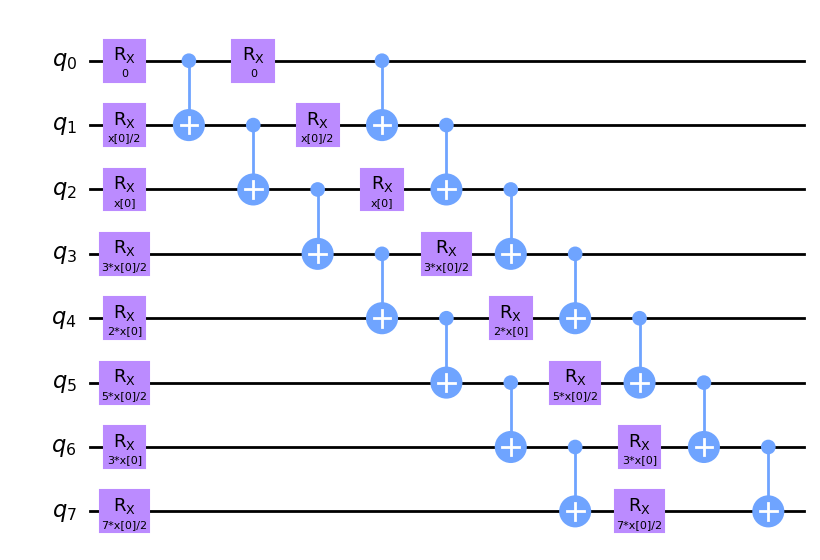

In [56]:
HardwareEfficientEmbeddingCircuit_qiskit(8, 2, "rx", only_one_variable=True).draw("mpl")

In [19]:
num_qubits = 8

x_span = np.linspace(0, 1, 20)
x_span = x_span.reshape(-1, 1)
#x_span_repeated = np.tile(x_span, (num_qubits, 1)).T

FQK_qnn, P0_coef = FQK_QNN(HardwareEfficientEmbeddingCircuit_qiskit, num_qubits = num_qubits, executor= Executor("statevector_simulator"), num_layers=2, rotation_gate="rx") 
K_f, K_dfdx = get_FQK_kernel_derivatives(x_span, FQK_qnn, P0_coef)

        ┌───────┐         ┌───────┐                                          »
q_0: ───┤ Rx(0) ├──────■──┤ Rx(0) ├───────────────────■──────────────────────»
      ┌─┴───────┴──┐ ┌─┴─┐└───────┘┌────────────┐   ┌─┴─┐                    »
q_1: ─┤ Rx(x[0]/2) ├─┤ X ├────■────┤ Rx(x[0]/2) ├───┤ X ├───────────■────────»
      └┬──────────┬┘ └───┘  ┌─┴─┐  └────────────┘┌──┴───┴───┐     ┌─┴─┐      »
q_2: ──┤ Rx(x[0]) ├─────────┤ X ├────────■───────┤ Rx(x[0]) ├─────┤ X ├──────»
     ┌─┴──────────┴─┐       └───┘      ┌─┴─┐     └──────────┘┌────┴───┴─────┐»
q_3: ┤ Rx(3*x[0]/2) ├──────────────────┤ X ├──────────■──────┤ Rx(3*x[0]/2) ├»
     └┬────────────┬┘                  └───┘        ┌─┴─┐    └──────────────┘»
q_4: ─┤ Rx(2*x[0]) ├────────────────────────────────┤ X ├───────────■────────»
     ┌┴────────────┴┐                               └───┘         ┌─┴─┐      »
q_5: ┤ Rx(5*x[0]/2) ├─────────────────────────────────────────────┤ X ├──────»
     └┬────────────┬┘                               

In [20]:
print("shapes")
print(K_f.shape)
print(K_dfdx.shape)

shapes
(20, 20)
(20, 20, 2)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


x_span = np.linspace(0, 1, 20)

kernel_list = np.array([K_f, K_dfdx[:,:,0]])

f_initial = 1
#insert x_initial in x_span

solution, optimal_alpha = solve(x_span, kernel_list, loss_function, f_initial)

shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218921575353
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218940188874
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218915550389
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218921986472
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218928528168
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218933077669
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218934726099
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218934096116
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218932675157
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
8165.218931715836
shapes
x_s

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


x_span = np.linspace(0, 1, 20)

kernel_list_rbf = np.array([rbf_kernel_manual(x_span, x_span, sigma=0.2), analytical_derivative_rbf_kernel(x_span, x_span, sigma=0.2)])

f_initial = 1
#insert x_initial in x_span

solution_rbf, optimal_alpha_rbf = solve(x_span, kernel_list_rbf, loss_function, f_initial)

shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304270167126
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304293012303
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304265248102
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304269595516
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.30427443766
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304279090433
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304283013207
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304285936192
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304287867819
shapes
x_span (20,)
kernel_order_0 (20, 20)
kernel_order_1 (20, 20)
alpha_ (21,)
11272.304289004534
s

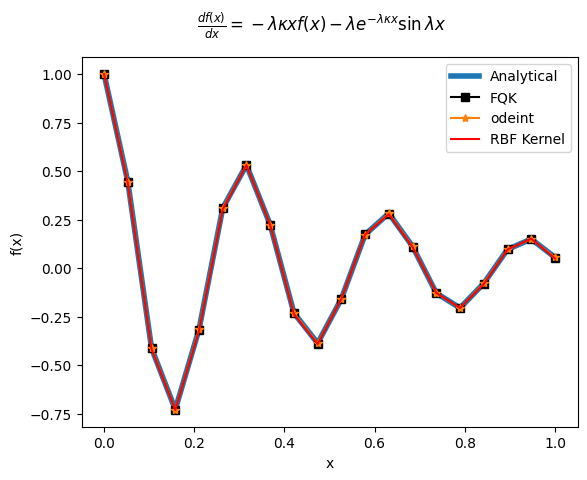

In [54]:
def f_analytical(x):
    lamb  = 20
    k = 0.1
    return np.exp(-lamb*x*k)*np.cos(lamb*x)


plt.plot(x_span[:], f_analytical(x_span[:]), '-', label='Analytical', linewidth=4)



f_values = odeint(g, f_initial, x_span[:])

plt.plot(x_span[:], solution, "s-",c= "black", label='FQK')
plt.plot(x_span[:], f_values, '*-', label='odeint')
plt.plot(x_span[:], solution_rbf, c= "red", label='RBF Kernel')

plt.suptitle(r'$\frac{df(x)}{dx} = - \lambda \kappa x f(x) - \lambda e^{-\lambda \kappa x} \sin{\lambda x}$')

plt.ylabel('f(x)')
plt.xlabel('x')
plt.legend()

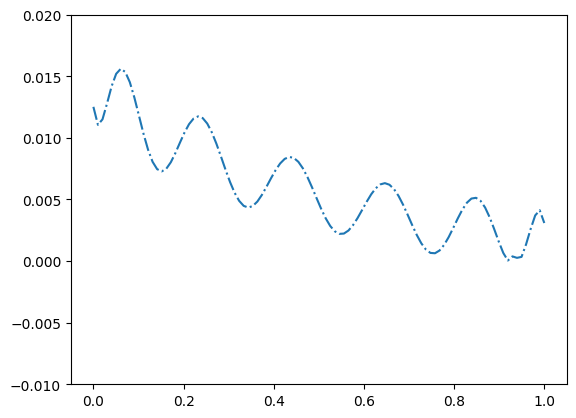

In [7]:
#plot error of solution and odeint
plt.ylim(-0.01, 0.02)
plt.plot(x_span, np.abs(solution-f_analytical(x_span)), '-.')